# Corteva Test
#### Problem 1:
   Calculate for each weather data file the number of days in which the maximum temperature and minimum temperature data are present but the precipitation data is missing. The program should create one line of output for each of the weather data files.
#### Problem 2
   Calculate average max temperature, min temperature, and total accumulated precipitation for every year for every station
#### Problem 3
   Calculate the frequency of each year from 1985-2014 had the highest average maximum temperature, highest average minimum temperature, and highest total accumulated precipitation from the set of weather stations.
#### Problem 4
   Calculate the Pearson correlation between weather variables and the grain yield data
    
**Note:** All outputs can be found under folder ./answers

## Load Packages
Load reqiured packages

In [72]:
import numpy as np
import pandas as pd
import os
from datetime import date

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
import glob 
import os
from datetime import datetime
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

Assign paths to input and output folders

In [73]:
weather_dir = './wx_data'  # input weather data
yield_dir = './yld_data'  # input corn yield data
answer_dir = './answers'  # folder to store outputs

## Explore Weather Data
Explore the weather data with specific attention to missing data

In [8]:
weather_list = os.listdir(weather_dir)
print(f'Number of weather stations: {len(weather_list)}')

Number of weather stations: 167


In [26]:
# get total number of dates between 1/1/1985 to 12/31/2014
def get_num_dates(begin, end):
    """
    Get number of days between two given dates
    
    Parameters
    ----------
    begin: datetime
        begining date
    end: datetime
        end date

    Returns
    -------
        number of days
    """
    
    delta = end - begin
    return delta.days

total_days = get_num_dates(date(1985,1,1), date(2014,12,31)) + 1
print(f'Total number of days between 1-Jan-1985 to 31-Dec-2014: {total_days}')

Total number of days between 1-Jan-1985 to 31-Dec-2014: 10957


In [27]:
# check number of missing dates in each file
for src in weather_list:
    df = pd.read_csv(os.path.join(weather_dir, src), 
                       header=None, 
                       names=['date', 'maxt', 'mint', 'preci'],
                      sep='\t')
    data_len = len(df.index)
    if data_len != total_days:
        print(f'file {src_file} data length {data_len} is less than {total_days}')

file USC00259090.txt data length 9074 is less than 10957
file USC00259090.txt data length 10380 is less than 10957
file USC00259090.txt data length 10653 is less than 10957
file USC00259090.txt data length 10926 is less than 10957
file USC00259090.txt data length 10866 is less than 10957
file USC00259090.txt data length 10836 is less than 10957
file USC00259090.txt data length 9587 is less than 10957
file USC00259090.txt data length 10017 is less than 10957
file USC00259090.txt data length 10654 is less than 10957
file USC00259090.txt data length 10927 is less than 10957
file USC00259090.txt data length 10807 is less than 10957
file USC00259090.txt data length 6087 is less than 10957
file USC00259090.txt data length 10926 is less than 10957
file USC00259090.txt data length 8735 is less than 10957
file USC00259090.txt data length 8489 is less than 10957
file USC00259090.txt data length 10075 is less than 10957
file USC00259090.txt data length 9862 is less than 10957
file USC00259090.txt

## Solve the Problems

### Problem 1

Calculate for each weather data file the number of days in which the maximum temperature and minimum temperature data are present but the precipitation data is missing. The program should create one line of output for each of the weather data files.

In [101]:
def MissingPrcpData(weather_dir, answer_dir):
    """
    Calculate for each weather data file the number of days in which 
    the maximum temperature and minimum temperature data 
    are present but the precipitation data is missing.
    
    Parameters
    ----------
    weather_dir: str
        directory of the weather data
    answer_dir: str
        directory to store the output file

    Returns
    -------
    output_df: dataframe
        dataframe includes weather station filename and number of missing precipation date

    """

    # sort weather data files in ascending order
    sorted_weather_data_file = sorted(os.listdir(weather_dir))

    # define output dataframe
    output_df = pd.DataFrame(columns = ['WeatherStation', 'MissingPrcpData'])
    for idx, weather_stateion in enumerate(sorted_weather_data_file): 
        file_path         = os.path.join(weather_dir, weather_stateion) 
        weather_df = pd.read_csv(file_path, header=None, names=['date', 'maxt', 'mint', 'preci'],
                                 sep='\t', parse_dates=[0])

        missing_preci_df = weather_df.loc[(weather_df.maxt !=-9999) & 
                                          (weather_df.mint !=-9999) &
                                          (weather_df.preci == -9999)]

        output_df.loc[idx,:] = [weather_stateion, len(missing_preci_df.index)]

    # Write the output in ascending order by filename and store it in the 
    # file 'MissingPrcpData.out' in the answers folder
    out_full_path = os.path.join(answer_dir, 'MissingPrcpData.out')
    output_df.to_csv(out_full_path, sep='\t', index=False, header=False)
    print(f'Results were saved to file: {out_full_path}')

    return output_df

In [102]:
MissingPrcpDataDF = MissingPrcpData(weather_dir, answer_dir)
MissingPrcpDataDF

Results were saved to file: ./answers/MissingPrcpData.out


,WeatherStation,MissingPrcpData
0,USC00110072.txt,121
1,USC00110187.txt,6
2,USC00110338.txt,22
3,USC00111280.txt,92
4,USC00111436.txt,125
...,...,...
162,USC00338552.txt,8
163,USC00338769.txt,7
164,USC00338822.txt,9
165,USC00338830.txt,201


### Problem 2
Calculate average max temperature, min temperature, and total accumulated precipitation for every year for every station.  
**Note:** convert temperature unit to **degrees Celsius** and precipitation to **centimeters**.

In [103]:
def YearlyAverages(weather_dir, answer_dir):
    """
    Calculate average max temperature, min temperature, and total accumulated precipitation
    for every year for every station.
        
    Parameters
    ----------
    weather_dir: str
        directory of the weather data
    answer_dir: str
        directory to store the output file

    Returns
    -------
    output_df: dataframe
        dataframe includes weather station filename and avaraged temperature and precipitation

    """

    # sort weather data files in ascending order
    sorted_weather_data_file = sorted(os.listdir(weather_dir))
    
    # define output dataframe
    output_df = pd.DataFrame(columns = ['WeatherStation', 'Year', 'MaxTempAvg', 'MinTempAvg', 'AccPrcp'])
    num = 0
    for idx, weather_stateion in enumerate(sorted_weather_data_file): 
        file_path         = os.path.join(weather_dir, weather_stateion) 
        weather_df = pd.read_csv(file_path, header=None, names=['date', 'maxt', 'mint', 'preci'],sep='\t', parse_dates=[0])

        # add year column to the dataframe
        weather_df['Year'] = weather_df['date'].dt.year

        group_by_year_df    = weather_df.groupby(by = 'Year')
        for year, year_df in group_by_year_df: 
            avg_max_temp     = year_df.loc[year_df['maxt'] != -9999, 'maxt'].mean()
            avg_min_temp     = year_df.loc[year_df['mint'] != -9999, 'mint'].mean()
            accumelated_prep = year_df.loc[year_df['preci'] != -9999, 'preci'].sum()
            output_df.loc[num,:] = [weather_stateion, year, avg_max_temp, avg_min_temp, accumelated_prep]

            num+=1

        # fill nan to years missing all avg_max_temp, avg_min_temp, accumelated_prep
        full_year_arr = np.arange(1985, 2015)
        temp_df = output_df.loc[output_df['WeatherStation']==weather_stateion]
        unuqe_years = pd.unique(temp_df['Year'])
        missing_years = full_year_arr[~np.isin(full_year_arr,unuqe_years)]
        if len(missing_years) > 0:
            for year in missing_years:
                output_df.loc[num,:] = [weather_stateion, year, np.NAN, np.NAN, np.NAN]

                num+=1

    # change unit to degrees Celsius and centimeters
    output_df['MaxTempAvg'] = output_df['MaxTempAvg'] / 10.0
    output_df['MinTempAvg'] = output_df['MinTempAvg'] / 10.0
    output_df['AccPrcp'] = output_df['AccPrcp'] / 100.0

    # keep two decimals for numerical columns
    output_df['MaxTempAvg'] = output_df['MaxTempAvg'].apply(lambda x: round(x, 2))
    output_df['MinTempAvg'] = output_df['MinTempAvg'].apply(lambda x: round(x, 2))
    output_df['AccPrcp'] = output_df['AccPrcp'].apply(lambda x: round(x, 2))


    # fill nan with -9999.00
    output_df = output_df.fillna(-9999.00)

    # Write the output in ascending order by filename and store it in the file 'YearlyAverages.out'
    # in the answers folder
    out_full_path = os.path.join(answer_dir, 'YearlyAverages.out')
    output_df.to_csv(out_full_path, sep='\t', index=False, header=False)
    print(f'Results were saved to file: {out_full_path}')

    return output_df

In [104]:
YearlyAverageDf = YearlyAverages(weather_dir, answer_dir)
YearlyAverageDf

Results were saved to file: ./answers/YearlyAverages.out


,WeatherStation,Year,MaxTempAvg,MinTempAvg,AccPrcp
0,USC00110072.txt,1985,15.33,4.33,78.01
1,USC00110072.txt,1986,12.70,2.18,50.53
2,USC00110072.txt,1987,17.76,6.33,79.36
3,USC00110072.txt,1988,17.35,4.53,54.10
4,USC00110072.txt,1989,15.65,3.98,79.37
...,...,...,...,...,...
5005,USC00339312.txt,2010,16.17,4.33,103.40
5006,USC00339312.txt,2011,16.31,5.05,136.07
5007,USC00339312.txt,2012,17.80,5.17,91.08
5008,USC00339312.txt,2013,15.47,4.02,109.90


### Problem 3
Calculate the frequency of each year from 1985-2014 had the highest average maximum temperature, highest average minimum temperature, and highest total accumulated precipitation from the set of weather stations.

In [105]:
def plot_frequency(YearFreq_df, answer_dir, FigName = None):
    """
    plot and save the frequency of each year had the highest values
    
    Parameters
    ----------
    YearFreq_df: dataframe
        dataframe include frequency of highest values in each year
    answer_dir: str
        directory to store the output file
    FigName: str
        name of the output plot
    
    """
    
    # define the plot
    fig, axs = plt.subplots(1, 1, figsize=(26,10))
    YearFreq_df.plot(x="Year", y=["YearFreqhMaxTemp", "YearFreqMinTemp", "YearFreqAccPrcp"],
                    ax = axs, ylabel  = 'Frequency', 
                    kind="bar", color= ['#58508d', '#ff6361', '#ffa600'], 
                    width=0.7, )
    
    # format the labels
    axs.set_xlabel('Year', fontsize=18)
    axs.set_ylabel('Frequency', fontsize=18)
    plt.setp(axs.xaxis.get_majorticklabels(), fontsize=16, rotation = 45)
    plt.setp(axs.yaxis.get_majorticklabels(), fontsize=16)
    
    # format the legend
    legend_labels = ['Highest Average Max Temp', 'Highest Average Min Temp', 'Highest Average Accumulated Precp']
    plt.legend(labels = legend_labels, loc = 'upper left', prop={'size': 18})
    
    # Add a vertical line across the Axes.
    x = 0.5
    for i in range(29):
        axs.axvline(x = x, linestyle = '--', color = '#808080', 
                    label = 'axvline - full height')
        x = x + 1
    
    # save the plot
    plot_path = os.path.join(answer_dir, FigName)
    plt.savefig(plot_path, dpi = 400)
    print(f'The histogram was saved to: {plot_path}')
    

def YearHistogram(year_average_df, answer_dir):

    """
    Calculate the frequency of each year had the highest average maximum temperature, highest average minimum 
    temperature, and highest total accumulated precipitation from the set of weather stations.

    Parameters
    ----------
    year_average_df: dataframe
        dataframe includes weather station filename and avaraged temperature and precipitation
        from function YearlyAverages
    answer_dir: str
        directory to store the output file

    Returns
    -------
    YearFreq_df: dataframe
        dataframe includes frequency of highest values in each year

    """
    # get the results from problem 2
    YearlyAverages_df = year_average_df

    # group results from problem 2 by weather station ID
    groupby_ws_df = YearlyAverages_df.groupby(by = 'WeatherStation')

    # temporary dataframe to store year of highest values for each weather station
    year_highest_df = pd.DataFrame(columns = ['WeatherStation', 'YearMaxTempAvg', 'YearMinTempAvg', 'YearAccPrcp'])

    for idx, (wstation, wstation_df) in enumerate(groupby_ws_df):
        year_highest_max_temp  = wstation_df.loc[wstation_df['MaxTempAvg'].idxmax(), 'Year'] 
        year_highest_min_temp  = wstation_df.loc[wstation_df['MinTempAvg'].idxmax(), 'Year'] 
        year_highest_acc_prep = wstation_df.loc[wstation_df['AccPrcp'].idxmax(), 'Year'] 
        year_highest_df.loc[idx,:] = [wstation, year_highest_max_temp, year_highest_min_temp, 
                                      year_highest_acc_prep]

    # calculate the frequency of each highest value year
    YearMaxTempAvg_freq = year_highest_df['YearMaxTempAvg'].value_counts()
    YearMinTempAvg_freq = year_highest_df['YearMinTempAvg'].value_counts()
    YearAccPrcp_freq = year_highest_df['YearAccPrcp'].value_counts()

    # create dafatame to store the frequency
    YearFreq_df = pd.DataFrame(0, index=np.arange(1985, 2015), columns = ['Year', 'YearFreqhMaxTemp', 
                               'YearFreqMinTemp', 'YearFreqAccPrcp'])

    YearFreq_df['Year']=YearFreq_df.index
    YearFreq_df['YearFreqhMaxTemp'].update(YearMaxTempAvg_freq)
    YearFreq_df['YearFreqMinTemp'].update(YearMinTempAvg_freq)
    YearFreq_df['YearFreqAccPrcp'].update(YearAccPrcp_freq)
    YearFreq_df = YearFreq_df.reset_index(drop=True)

    # Write the frequency of each year to the file "YearHistogram.out" in the answers folder
    out_full_path = os.path.join(answer_dir, 'YearHistogram.out')
    YearFreq_df.to_csv(out_full_path, sep='\t', index=False, header=False)
    print(f'Results were saved to file: {out_full_path}')

    # Plot the histogram and save as 'YearHistogram.png'
    plot_frequency(YearFreq_df, answer_dir, FigName = 'YearHistogram.png')

    return YearFreq_df

Results were saved to file: ./answers/YearHistogram.out
The histogram was saved to: ./answers/YearHistogram.png


,Year,YearFreqhMaxTemp,YearFreqMinTemp,YearFreqAccPrcp
0,1985,2,4,0
1,1986,1,2,5
2,1987,13,18,1
3,1988,6,5,0
4,1989,0,0,0
5,1990,2,2,23
6,1991,1,7,0
7,1992,0,0,2
8,1993,0,1,38
9,1994,0,2,0


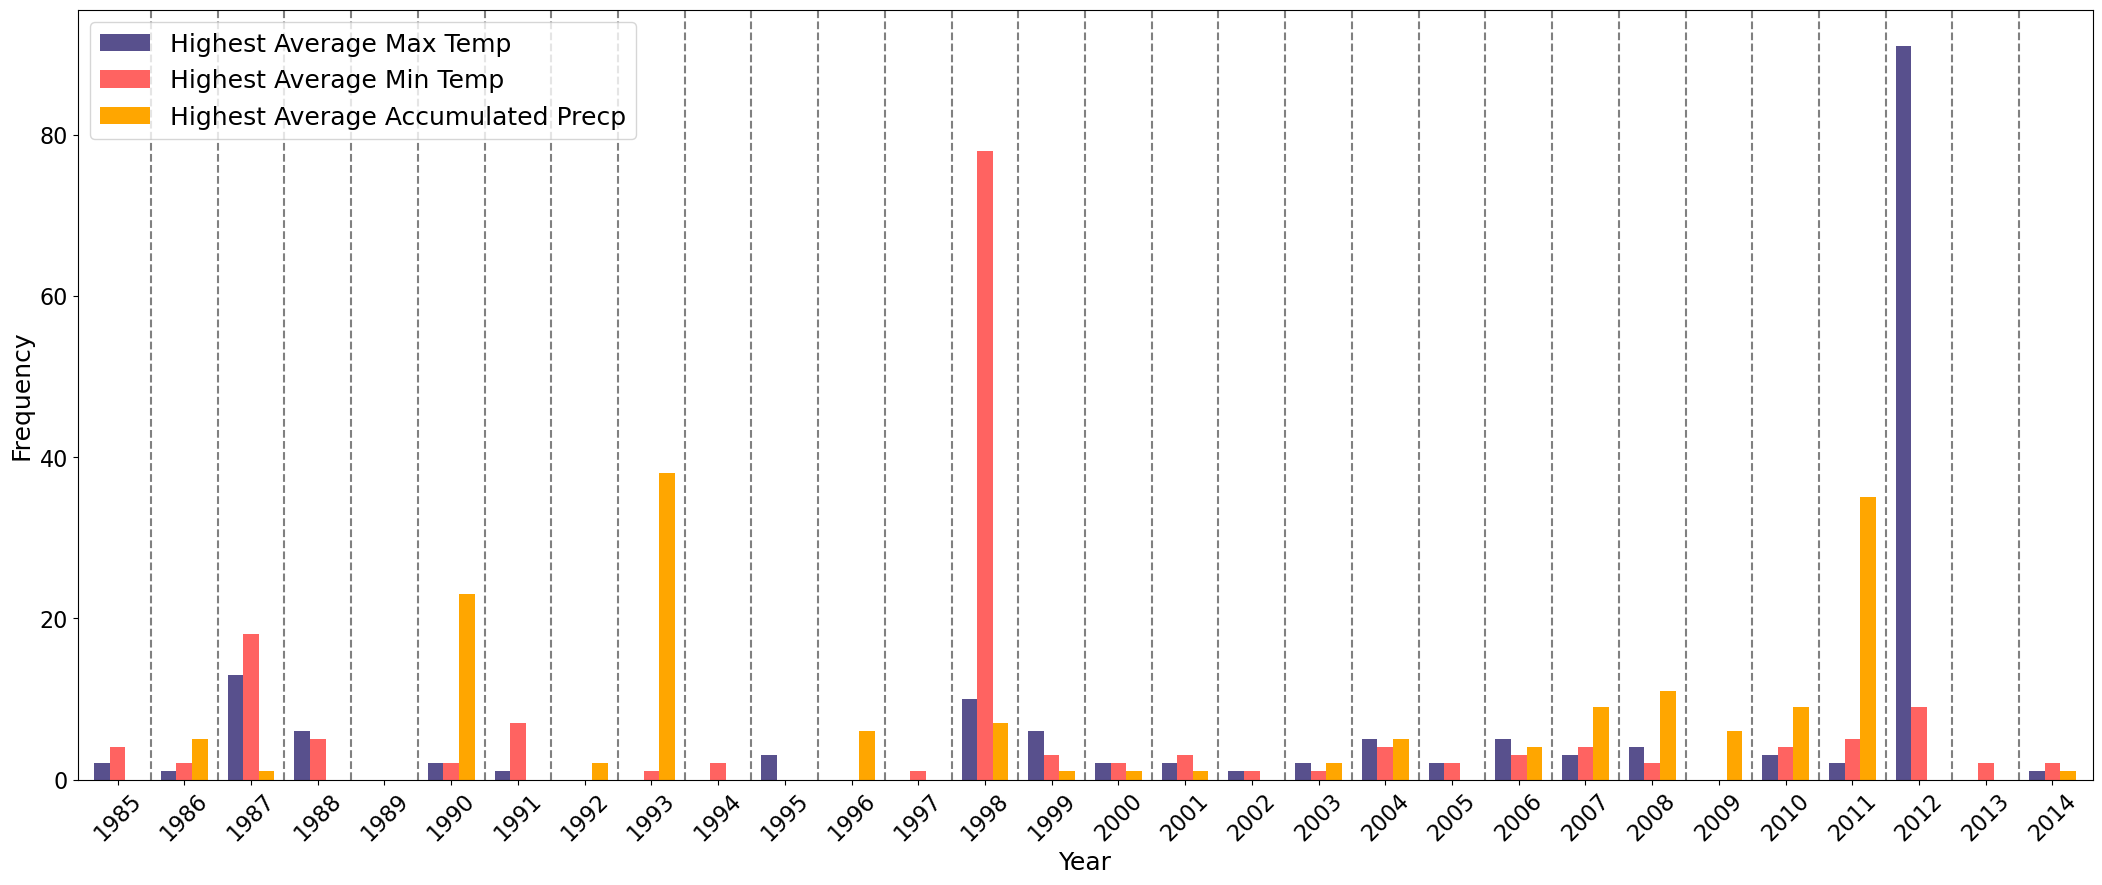

In [106]:
YearHistogramDf = YearHistogram(YearlyAverageDf, answer_dir)
YearHistogramDf

### Problem 4
Calculate the Pearson correlation between weather variables and the grain yield data

In [99]:
def Correlations(year_average_df, yield_dir, answer_dir):
    """
    Calculate the Pearson correlation between weather variables and the grain yield data

    Parameters
    ----------
    year_average_df: dataframe
        dataframe includes weather station filename and avaraged temperature and precipitation
        from function YearlyAverages
    yield_dir: str
        directory of the corn grain yield data
    answer_dir: str
        directory to store the output file

    Returns
    -------
    output_df: dataframe
        dataframe includes Pearson correlation between weather variables and the grain yield data

    """

    # get the results from problem 2
    YearlyAverages_df = year_average_df

    # read US corn grain yield data
    yield_path = os.path.join(yield_dir, 'US_corn_grain_yield.txt')
    yield_df  = pd.read_csv(yield_path, header=None, names=['Year', 'Yield'], sep = "\t")

    # merge YearlyAverages_df with yield_df
    YearlyAverages_df = YearlyAverages_df.merge(yield_df, left_on='Year', right_on='Year')

    # group by weather station ID
    groupby_ws_df = YearlyAverages_df.groupby(by = 'WeatherStation')

    output_df = pd.DataFrame(columns = ['WeatherStation', 'MaxTempYieldCorr', 'MinTempYieldCorr', 'PrcpYieldCorr'])

    # calculate Pearson correlation for each station
    for idx, (wstation, wstation_df) in enumerate(groupby_ws_df):
        # avarage max temp v.s. yield
        temp_df = wstation_df[['MaxTempAvg', 'Yield']]
        temp_df = temp_df[temp_df['MaxTempAvg'] != -9999.0] # drop rows with missing default value -9999.0
        MaxTempYield_Corr = stats.pearsonr(temp_df['MaxTempAvg'], temp_df['Yield'])[0]

        # avarage min temp v.s. yield
        temp_df = wstation_df[['MinTempAvg', 'Yield']]
        temp_df = temp_df[temp_df['MinTempAvg'] != -9999.0] # drop rows with missing default value -9999.0
        MinTempYield_Corr = stats.pearsonr(temp_df['MinTempAvg'], temp_df['Yield'])[0]

        # avarage accumulated precipitation v.s. yield
        temp_df = wstation_df[['AccPrcp', 'Yield']]
        temp_df = temp_df[temp_df['AccPrcp'] != -9999.0] # drop rows with missing default value -9999.0
        PrcpYield_Corr = stats.pearsonr(temp_df['AccPrcp'], temp_df['Yield'])[0]

        output_df.loc[idx,:] = [wstation, MaxTempYield_Corr, MinTempYield_Corr, PrcpYield_Corr]


    output_df['MaxTempYieldCorr'] = output_df['MaxTempYieldCorr'].apply(lambda x: round(x, 2))
    output_df['MinTempYieldCorr'] = output_df['MinTempYieldCorr'].apply(lambda x: round(x, 2))
    output_df['PrcpYieldCorr'] = output_df['PrcpYieldCorr'].apply(lambda x: round(x, 2))

    # Write the output to 'Correlations.out'
    out_full_path = os.path.join(answer_dir, 'Correlations.out')
    output_df.to_csv(out_full_path, sep='\t', index=False, header=False)
    print(f'Results were saved to file: {out_full_path}')

    return output_df

In [100]:
CorrelationsDf = Correlations(YearlyAverageDf, yield_dir, answer_dir)
CorrelationsDf

Results were saved to file: ./answers/Correlations.out


,WeatherStation,MaxTempYieldCorr,MinTempYieldCorr,PrcpYieldCorr
0,USC00110072.txt,-0.27,-0.29,0.21
1,USC00110187.txt,0.28,0.11,0.02
2,USC00110338.txt,-0.30,0.22,0.25
3,USC00111280.txt,-0.25,-0.33,-0.13
4,USC00111436.txt,0.10,0.01,0.09
...,...,...,...,...
162,USC00338552.txt,-0.09,0.08,0.02
163,USC00338769.txt,-0.26,-0.23,0.32
164,USC00338822.txt,-0.37,-0.37,0.26
165,USC00338830.txt,-0.27,0.29,0.18
